In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from tqdm.notebook import tqdm
tqdm.monitor_interval = 0


# Die beste Gemeinde des Kantons Graubünden

Gewählte Gemeinde: Furna
Nachbars Gemeinden (alphabetisch): Flims und Fürstenau

## Quellen

Ich habe die folgenden Quellen verwendet:

- [Gemeinde Codes Graubünden](https://www.gr.ch/DE/institutionen/verwaltung/dvs/alg/Dokumente%20Geoinformation/AV_HS_02_DE_Die_Gemeinden_des_Kantons_Graub%C3%BCnden.pdf)
- [Regional Portraits](https://www.bfs.admin.ch/bfs/de/home/statistiken/regionalstatistik/regionale-portraets-kennzahlen/gemeinden/daten-erlaeuterungen.assetdetail.15864450.html)
- [Verkehrsunfälle Kanton Graubünden 2023](https://www.gr.ch/DE/institutionen/verwaltung/djsg/kapo/service/statistik/Documents/VU%20Statistik%202022.pdf)
- [Standard nomenclature (NOAS04) by district and municipality, in hectares](https://www.pxweb.bfs.admin.ch/pxweb/en/px-x-0202020000_102/-/px-x-0202020000_102.px/)
- [Wikipedia: Gemeinden des Kantons Graubünden](https://de.wikipedia.org/wiki/Gemeinden_des_Kantons_Graub%C3%BCnden)

Für jede Quelle habe ich ein entsprechendes Script erstellt welches die relevanten Daten aus der Quelle extrahiert. Dateien aus den Quellen welche heruntergeladen werden können 
(.pdf, .xlsx) sind unter dem Dateipfad `./data/raw` abgelegt. Jedes Script speichert die aufbereiteten Daten in einer .csv Datei unter `./data/scraped`. Um die Skripts erneut
auszuführen, kann die Konstante `RUN_SCRIPTS` auf `True` gesetzt werden.


In [2]:
# zusätzliche dependencies der Scripts
import pdfplumber
import pyjstat
import openpyxl

RUN_SCRIPTS = False
if RUN_SCRIPTS: 
    !cd scrape && python extract-codes.py
    !cd scrape && python extract-regionalportraits.py
    !cd scrape && python extract-accidents.py
    !cd scrape && python fetch-districts.py
    !cd scrape && python scrape-wikipedia.py
else:
    print("scripts did not run; change constant RUN_SCRIPTS to rerun all scripts.")


scripts did not run; change constant RUN_SCRIPTS to rerun all scripts.


## Kriterien

Das Ranking der Gemeinden basiert auf 5 von mir erstellten Kriterien. Jede Gemeinde erhält bei jedem Kriterium einen Score zwischen 0 und 100. 
Später werden alle Scores verwendet, um einen gesamthaften Score zu berechnen. Die Scores basieren auf den Daten aus den Quellen, jedoch verwende
ich verschiedene statistische Methoden um die Verteilungen der einzelnen Scores und somit die Positionen der Gemeinden in der Rangliste zu
beeinflussen.


In [3]:
def plot_distribution(series, titel, x_label, y_label, color):
    plt.figure(figsize=(10, 6))
    sns.histplot(series, bins=30, kde=True, color=color, edgecolor='black')
    plt.title(titel)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()


### Kriterium 1: Durchschnittliche Waldfläche pro Person


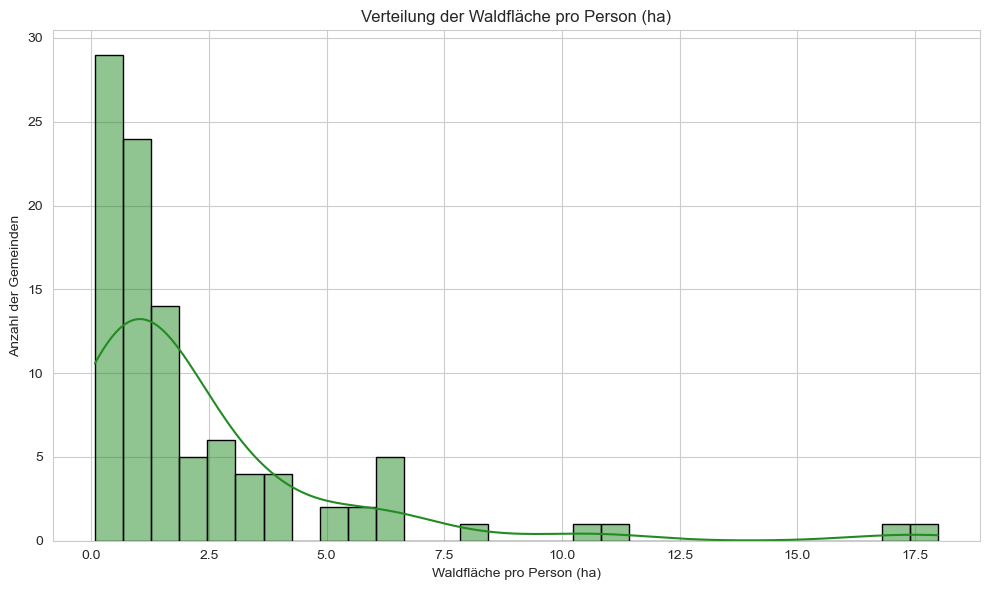

In [4]:
df_regio = pd.read_csv('./data/scraped/regionalportraits.csv')

df_regio["Forest_area_ha"] = df_regio["Total_Area_km2"] * df_regio["Forest_Vegetation_pct"]

# Berechne nun die durchschnittliche Waldfläche pro Person (in Hektaren)
df_regio["Forest_area_per_person_ha"] = df_regio["Forest_area_ha"] / df_regio["Population"]

plot_distribution(df_regio['Forest_area_per_person_ha'], 
                  "Verteilung der Waldfläche pro Person (ha)", 
                  "Waldfläche pro Person (ha)",
                  "Anzahl der Gemeinden",
                  'forestgreen')


### Kriterium 2: Familienfreundliche Gemeinden


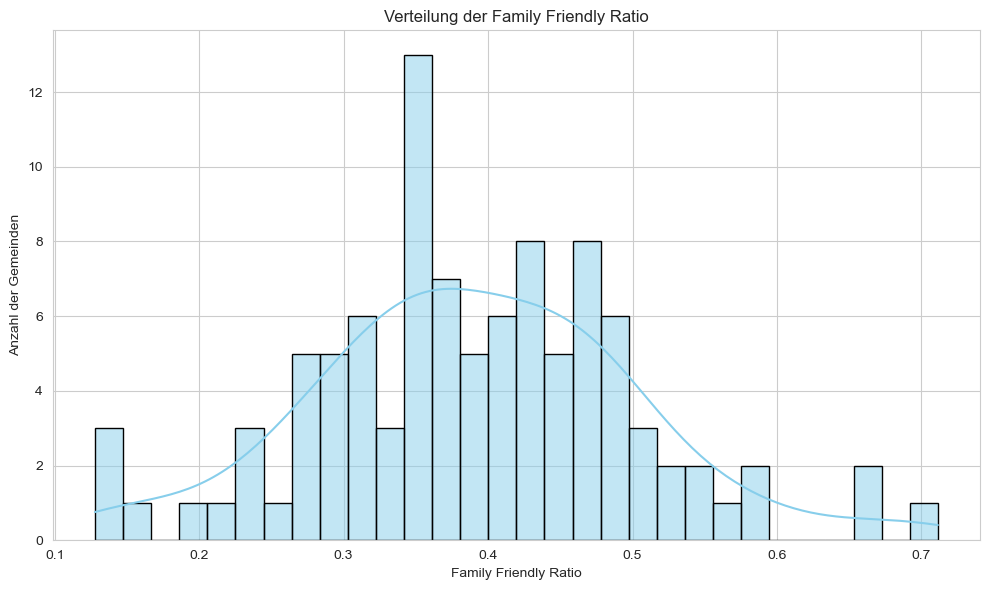

In [5]:
df_regio['Avg_Household_Size'] = df_regio['Population'] / df_regio['Households']
df_regio['Family_Friendly'] = df_regio['Avg_Household_Size'] * (df_regio['Age_0_19'] / 100)

plot_distribution(df_regio['Family_Friendly'],
                  "Verteilung der Family Friendly Ratio",
                  "Family Friendly Ratio",
                  "Anzahl der Gemeinden",
                  'skyblue')


### Kriterium 3: Wikipedia Artikel


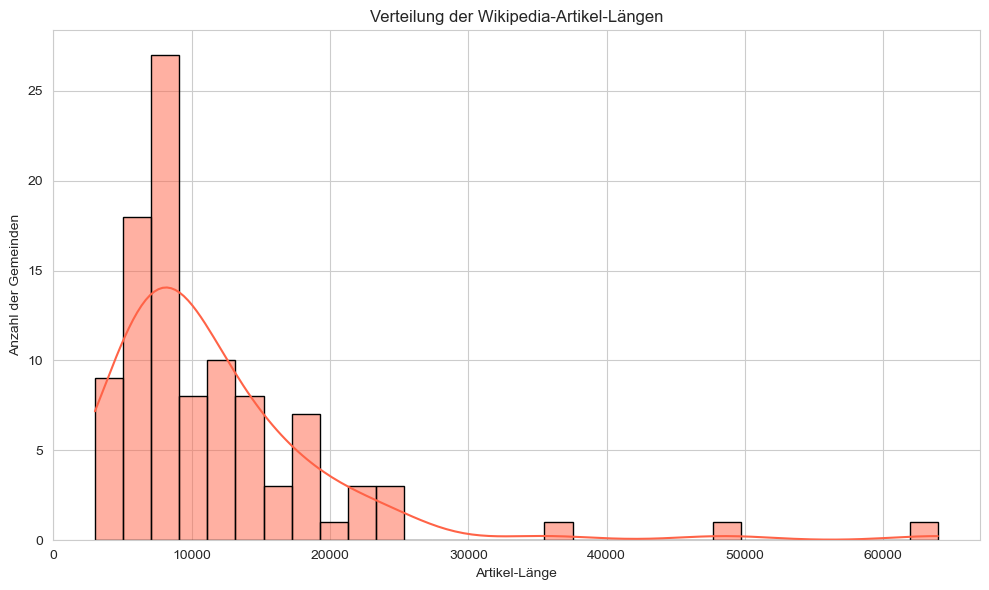

In [6]:
df_wiki = pd.read_csv('./data/scraped/wikipedia-length.csv')


plot_distribution(df_wiki['Artikel_Laenge'],
                  "Verteilung der Wikipedia-Artikel-Längen",
                  "Artikel-Länge",
                  "Anzahl der Gemeinden",
                  'tomato')


### Kriterium 4: Verkehrsunfälle


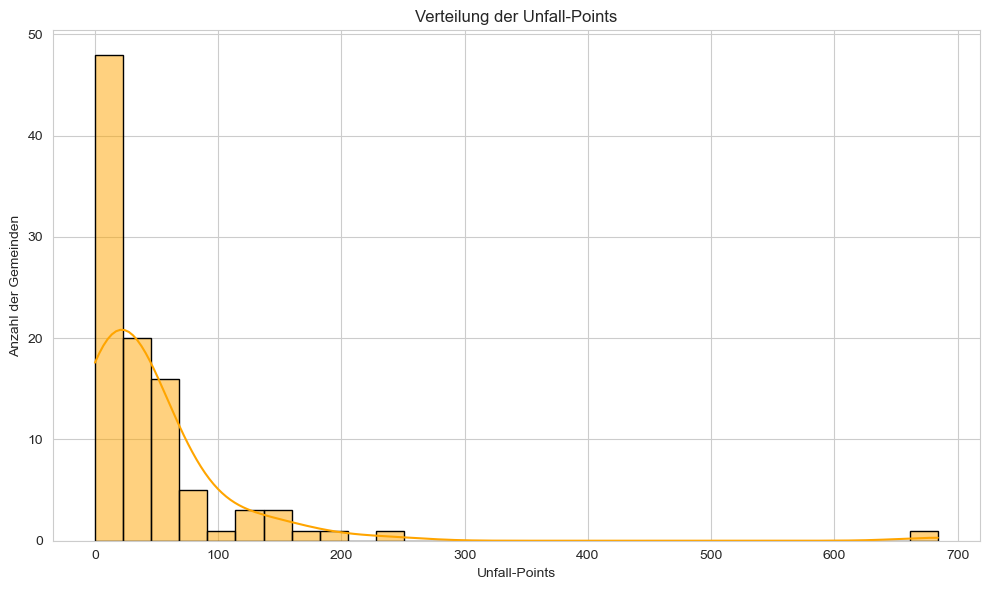

In [7]:
df_accidents = pd.read_csv('./data/scraped/accidents.csv')

multiplier_sach = 1
multiplier_person = 2
multiplier_getoetete = 20
multiplier_schwer = 10
multiplier_lebensbedrohlich = 15
multiplier_erheblich = 5

df_accidents["Accident_points"] = (
        df_accidents["Unfälle-mit-Sachschaden"] * multiplier_sach +
        df_accidents["Unfälle-mit-Personenschaden"] * multiplier_person +
        df_accidents["Getötete"] * multiplier_getoetete +
        df_accidents["Schwerverletzte"] * multiplier_schwer +
        df_accidents["Lebensbedrohlich-Verletzte"] * multiplier_lebensbedrohlich +
        df_accidents["Erheblich-Verletzte"] * multiplier_erheblich
)

plot_distribution(df_accidents["Accident_points"],
                  "Verteilung der Unfall-Points",
                  "Unfall-Points",
                  "Anzahl der Gemeinden",
                  'orange')


### Kriterium 5: Strassenfläche


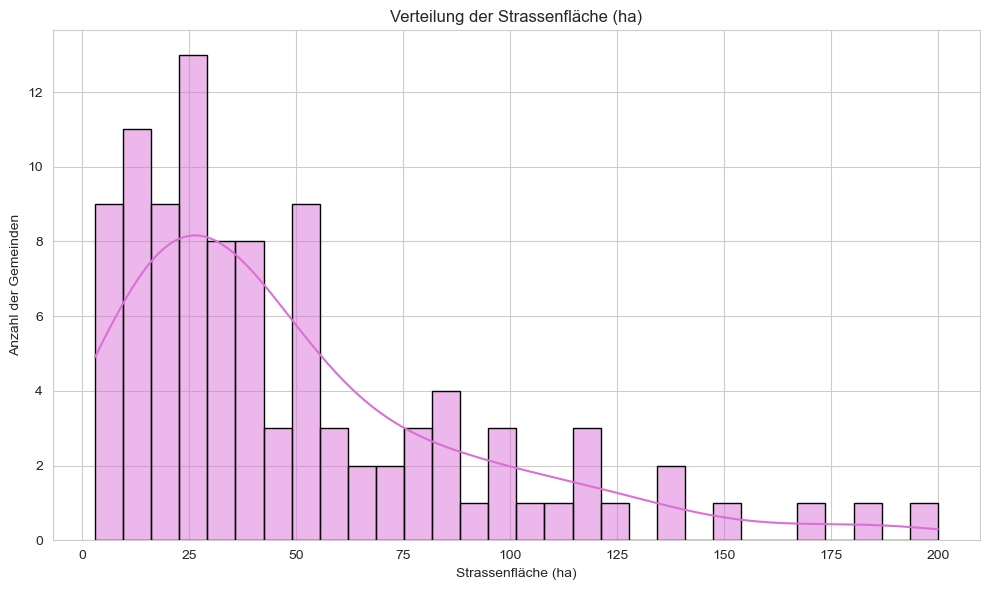

In [8]:
df_streets = pd.read_csv('./data/scraped/streets.csv')

plot_distribution(df_streets['Strassenflaeche-Hektar'],
                  "Verteilung der Strassenfläche (ha)",
                  "Strassenfläche (ha)",
                  "Anzahl der Gemeinden",
                  'orchid')


## Rangliste

### Transformationen


In [9]:
def normalize(series):
    return 100 * (series - series.min()) / (series.max() - series.min())

def log_and_normalize(series):
    return normalize(np.log1p(series))

def boxcox_and_normalize(series):
    if series.min() <= 0:
        series = series + abs(series.min()) + 1e-6
    transformed, lam = boxcox(series.values)
    return normalize(pd.Series(transformed))

def standardize_and_normalize(series):
    standardized = (series - series.mean()) / series.std()
    return normalize(standardized)

def robust_scale_and_normalize(series):
    robust_scaled = (series - series.median()) / (series.quantile(0.75) - series.quantile(0.25))
    return normalize(robust_scaled)

def yeo_johnson_and_normalize(series):
    pt = PowerTransformer(method='yeo-johnson')
    transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
    return normalize(pd.Series(transformed))

def quantile_transform_and_normalize(series):
    n_quantiles = min(1000, len(series))
    qt = QuantileTransformer(n_quantiles=n_quantiles, output_distribution='normal')
    transformed = qt.fit_transform(series.values.reshape(-1, 1)).flatten()
    return normalize(pd.Series(transformed))

scores = [
    "Forest_score",
    "Family_score",
    "Wiki_score",
    "Accident_score",
    'Street_score'
]

transformation_candidates = [
    normalize,
    log_and_normalize,
    boxcox_and_normalize,
    standardize_and_normalize,
    robust_scale_and_normalize,
    yeo_johnson_and_normalize,
    quantile_transform_and_normalize
]

def calculate_scores(df, trans_funcs):
    df["Forest_score"] = trans_funcs["Forest_score"]( df_regio["Forest_area_per_person_ha"] )
    df["Family_score"] = trans_funcs["Family_score"]( df_regio["Family_Friendly"] )
    df["Wiki_score"]   = trans_funcs["Wiki_score"]( df_wiki["Artikel_Laenge"] )
    df["Accident_score"] = 100 - trans_funcs["Accident_score"]( df_accidents["Accident_points"] )
    df["Street_score"] = trans_funcs["Street_score"]( df_streets["Strassenflaeche-Hektar"] )
    return df



### Gewichte

In [94]:

relevant_communities = ['Furna', 'Flims', 'Fürstenau']

initial_weights = {
    # 'Forest_score': 0.2,
    # 'Family_score': 0.2,
    # 'Wiki_score': 0.2,
    # 'Accident_score': 0.2,
    # 'Street_score': 0.2
    'Forest_score': 0.291,
    'Family_score': 0.171,
    'Wiki_score': 0.135,
    'Accident_score': 0.213,
    'Street_score': 0.187
}

def calculate_final_score(df, weights):
    df['Final_Score'] = (
            df['Forest_score'] * weights['Forest_score'] +
            df['Family_score'] * weights['Family_score'] +
            df['Wiki_score'] * weights['Wiki_score'] +
            df['Accident_score'] * weights['Accident_score'] +
            df['Street_score'] * weights['Street_score']
    )
    df['Final_Score'] = df['Final_Score'].round(1)
    return df.sort_values(by='Final_Score', ascending=False).reset_index(drop=True)


Konfigurationen Evaluieren:   0%|          | 0/1000 [00:00<?, ?it/s]

Beste Konfiguration gefunden:
Gewichtungen:
{'Forest_score': 0.32114468649943934, 'Family_score': 0.21760985262624558, 'Wiki_score': 0.32266787875452424, 'Accident_score': 0.13245737008918415, 'Street_score': 0.006120212030606763}
Transformationen:
{'Forest_score': <function yeo_johnson_and_normalize at 0x11e98f100>, 'Family_score': <function log_and_normalize at 0x11e98dda0>, 'Wiki_score': <function yeo_johnson_and_normalize at 0x11e98f100>, 'Accident_score': <function log_and_normalize at 0x11e98dda0>, 'Street_score': <function standardize_and_normalize at 0x11e98f2e0>}
Zielfunktionswert (Flims + Fürstenau Rang): 193.00


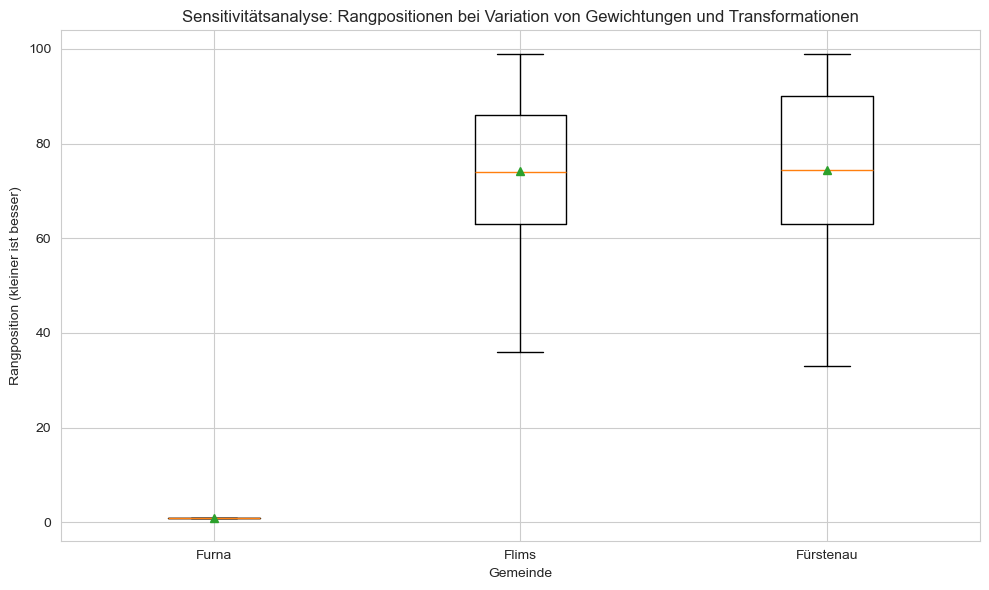

In [110]:
def find_best_config(n_iter=10000):
    best_config = None
    best_objective = -1
    ranking_results = {community: [] for community in relevant_communities}

    for _ in tqdm(range(n_iter), desc='Konfigurationen Evaluieren'):
        df_base = df_regio[['Gemeinde']].copy()
        trans_funcs = {}
        for score in scores:
            chosen_func = np.random.choice(transformation_candidates)
            trans_funcs[score] = chosen_func

        df_base = calculate_scores(df_base, trans_funcs)

        new_weights = {key: np.random.uniform(0, 1) for key in initial_weights}
            
        # new_weights = {}
        # for key, value in initial_weights.items():
        #     new_weights[key] = value * np.random.uniform(0.5, 1.5)
            
        total = sum(new_weights.values())
        for key in new_weights:
            new_weights[key] /= total
            
        df_base = calculate_final_score(df_base, new_weights)

        furna_rank = df_base[df_base["Gemeinde"] == "Furna"].index[0] + 1
        flims_rank = df_base[df_base["Gemeinde"] == "Flims"].index[0] + 1
        fuerstenau_rank = df_base[df_base["Gemeinde"] == "Fürstenau"].index[0] + 1

        if furna_rank == 1:
            ranking_results["Furna"].append(furna_rank)
            ranking_results["Flims"].append(flims_rank)
            ranking_results["Fürstenau"].append(fuerstenau_rank)
            
            objective = flims_rank + fuerstenau_rank
            if objective > best_objective:
                best_objective = objective
                best_config = {
                    'weights': new_weights.copy(),
                    'transformations': {key: trans_funcs[key] for key in trans_funcs},
                    'objective': best_objective
                }

    if best_config is not None:
        print("Beste Konfiguration gefunden:")
        print("Gewichtungen:")
        print(best_config['weights'])
        print("Transformationen:")
        print(best_config['transformations'])
        print(f"Zielfunktionswert (Flims + Fürstenau Rang): {best_config['objective']:.2f}")
    else:
        print("Keine Konfiguration gefunden, bei der Furna auf Rang 1 liegt.")

    # Visualisierung der Rangverteilungen
    plt.figure(figsize=(10, 6))
    data_to_plot = [ranking_results[com] for com in relevant_communities]
    plt.boxplot(data_to_plot, tick_labels=relevant_communities, showmeans=True)
    plt.xlabel('Gemeinde')
    plt.ylabel('Rangposition (kleiner ist besser)')
    plt.title('Sensitivitätsanalyse: Rangpositionen bei Variation von Gewichtungen und Transformationen')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_config

calculated_config = find_best_config(n_iter=1000)


,Gemeinde,Forest_score,Family_score,Wiki_score,Accident_score,Street_score
0,Vaz/Obervaz,27.821074,43.453495,68.894096,37.040739,43.147208
1,Lantsch/Lenz,49.166858,41.956700,67.181254,39.782916,10.659898
2,Schmitten (GR),68.704537,21.072548,86.782284,35.153394,2.030457
3,Albula/Alvra,71.980754,41.681151,53.804387,83.174425,49.238579
4,Surses,64.924521,31.011495,26.140036,53.372229,68.527919
...,...,...,...,...,...,...
95,Medel (Lucmagn),85.276024,17.794365,77.728232,38.626495,2.030457
96,Sumvitg,66.128826,38.021562,57.895335,19.479888,12.690355
97,Tujetsch,49.273878,37.434113,39.008046,70.197805,7.614213
98,Trun,52.014741,42.309573,48.053051,32.697698,59.898477


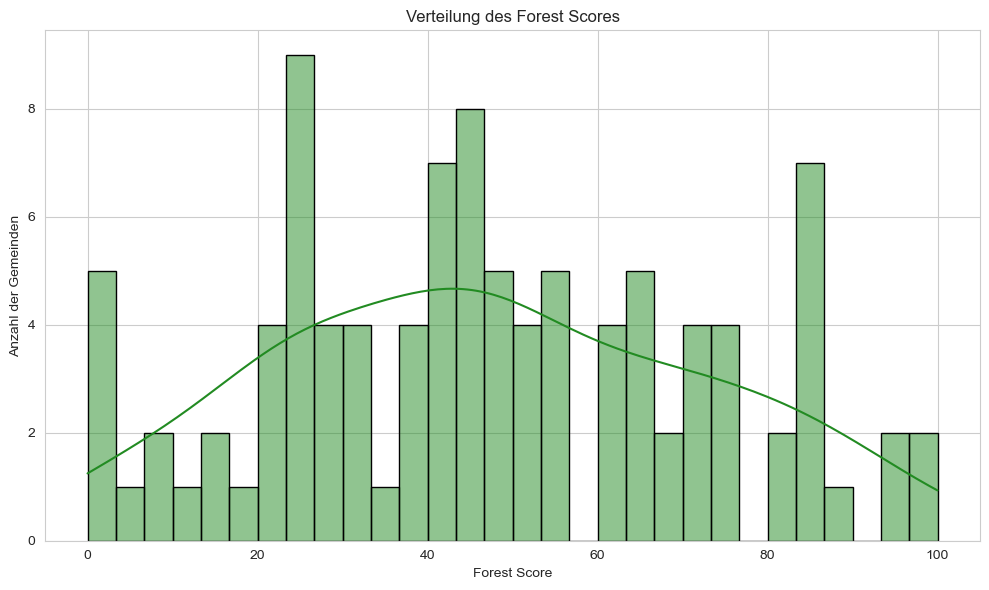

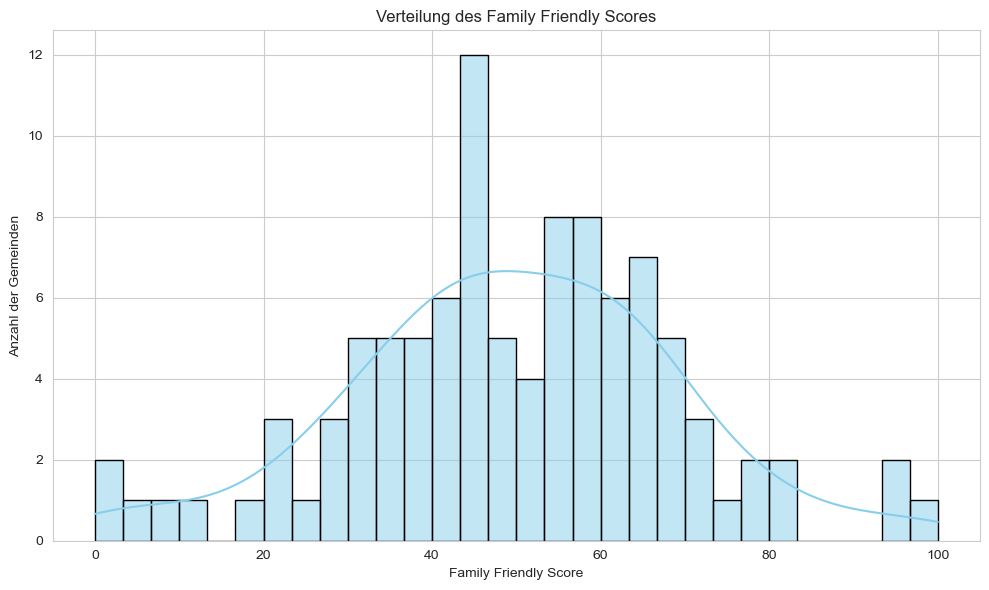

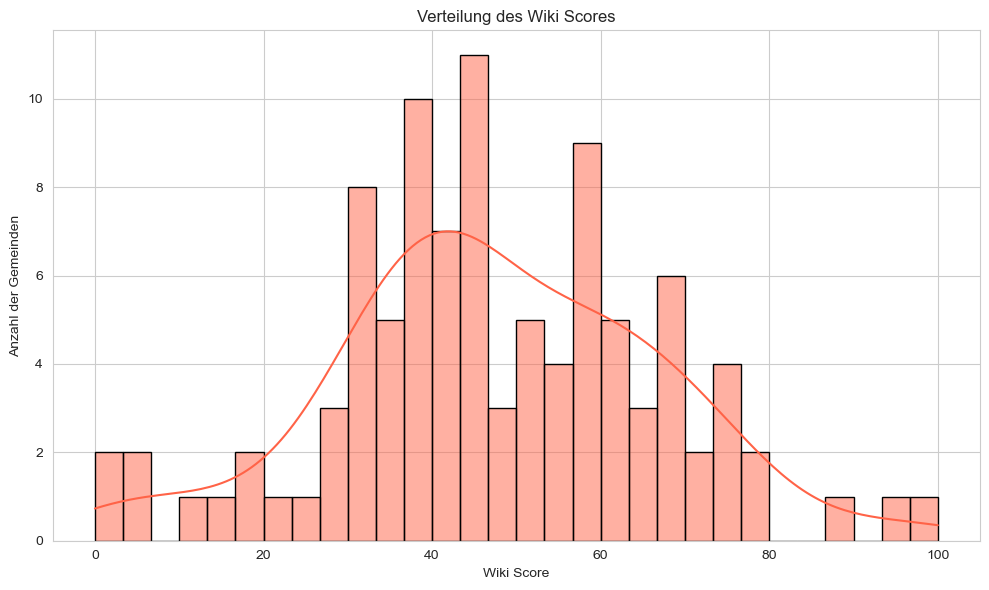

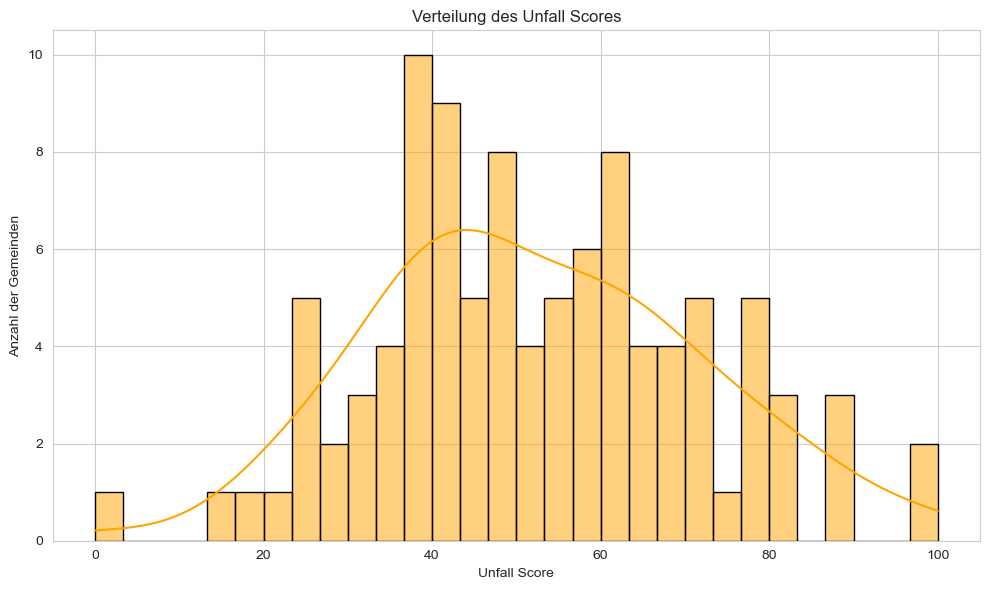

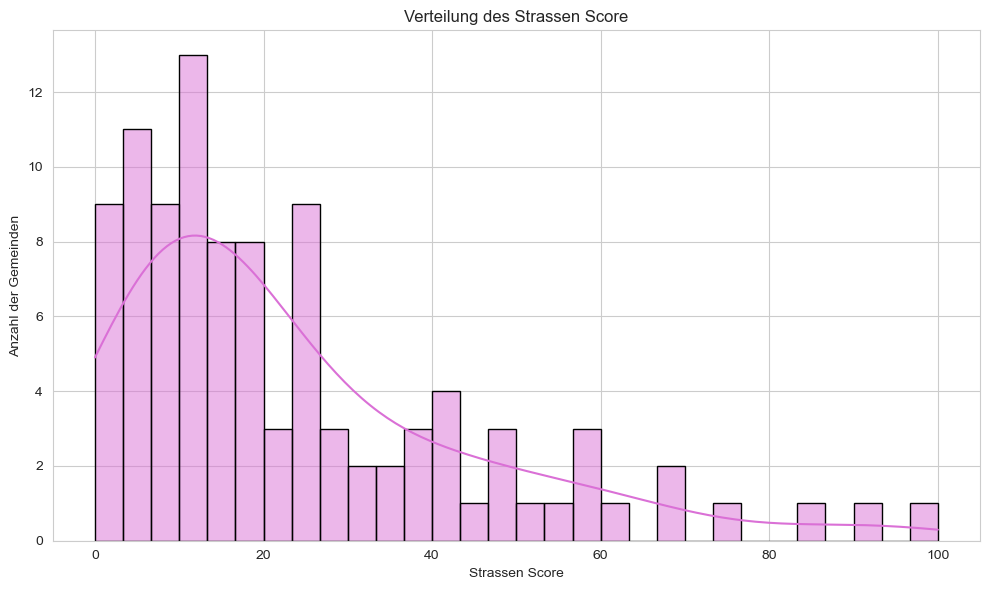

In [111]:
best_transformations = {
    'Forest_score': normalize,
    'Family_score': robust_scale_and_normalize,
    'Wiki_score': normalize,
    'Accident_score': boxcox_and_normalize,
    'Street_score': yeo_johnson_and_normalize
}

df_rank = df_regio[['Gemeinde']].copy()
# df_rank = calculate_scores(df_rank, best_transformations)
df_rank = calculate_scores(df_rank, calculated_config['transformations'])
display(df_rank)

plot_distribution(df_rank['Forest_score'],
                  "Verteilung des Forest Scores",
                  "Forest Score",
                  "Anzahl der Gemeinden",
                  'forestgreen')


plot_distribution(df_rank['Family_score'],
                  "Verteilung des Family Friendly Scores",
                  "Family Friendly Score",
                  "Anzahl der Gemeinden",
                  'skyblue')

plot_distribution(df_rank['Wiki_score'],
                  "Verteilung des Wiki Scores",
                  "Wiki Score",
                  "Anzahl der Gemeinden",
                  'tomato')

plot_distribution(df_rank["Accident_score"],
                  "Verteilung des Unfall Scores",
                  "Unfall Score",
                  "Anzahl der Gemeinden",
                  'orange')

plot_distribution(df_rank['Street_score'],
                  "Verteilung des Strassen Score",
                  "Strassen Score",
                  "Anzahl der Gemeinden",
                  'orchid')


,Gemeinde,Forest_score,Family_score,Wiki_score,Accident_score,Street_score,Final_Score
0,Furna,85.476702,93.655468,72.046135,27.463706,46.192893,75.0
94,Fürstenau,3.037942,62.787797,43.091447,46.449942,10.152284,34.8
97,Flims,23.534878,30.889631,38.682727,50.701955,40.101523,33.7


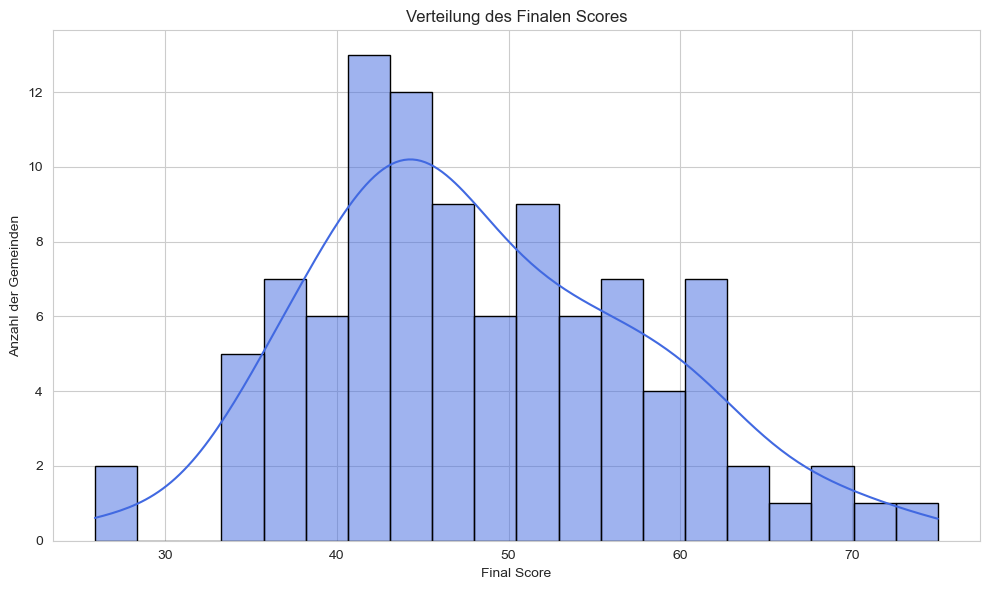

In [112]:
best_weights = {
    'Forest_score': 0.291,
    'Family_score': 0.171,
    'Wiki_score': 0.135,
    'Accident_score': 0.213,
    'Street_score': 0.187
}

# df_rank = calculate_final_score(df_rank, best_weights)
df_rank = calculate_final_score(df_rank, calculated_config['weights'])

selected_df = df_rank[df_rank['Gemeinde'].isin(relevant_communities)]
display(selected_df)
# print(selected_df)

plt.figure(figsize=(10, 6))
sns.histplot(df_rank['Final_Score'], bins=20, kde=True, color='royalblue', edgecolor='black')
plt.title('Verteilung des Finalen Scores')
plt.xlabel('Final Score')
plt.ylabel('Anzahl der Gemeinden')
plt.tight_layout()
plt.show()


In [ ]:
df_display = df_rank.rename(columns={
    'Forest_score': 'Forest Score',
    'Family_score': 'Family Score',
    'Wiki_score': 'Wiki Score',
    'Accident_score': 'Accident Score',
    'Street_score': 'Street Score',
    'Final_Score': 'Final Score',
})

df_display.to_csv('./data/ranking.csv', index=True)

styled_df = df_display.style \
    .set_caption("Rangliste der Gemeinden") \
    .background_gradient(cmap='viridis') \
    .format({
    'Forest Score': "{:.1f}",
    'Family Score': "{:.1f}",
    'Wiki Score': "{:.1f}",
    'Accident Score': "{:.1f}",
    'Street Score': "{:.1f}",
    'Final Score': "{:.1f}"
})

display(styled_df)
